In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
SEED = 42
BASE_DIR = 'data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')

np.random.seed(SEED)
random.seed(SEED)
for split in [TRAIN_DIR, VAL_DIR]:
    os.makedirs(os.path.join(split, 'horizontal'), exist_ok=True)
    os.makedirs(os.path.join(split, 'vertical'), exist_ok=True)
    os.makedirs(os.path.join(split, 'oblique'), exist_ok=True)

print(f"Dataset directories created inside '{BASE_DIR}'")

Dataset directories created inside 'data'


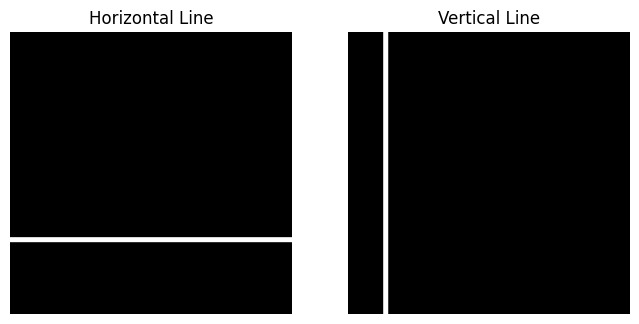

In [ ]:
IMG_SIZE = 224
LENGTH = 4
IMG_PER_CLASS = 100
PATCH_SIZE = 16

def generate_line_image(size: int, o: str, l: int):
    image = np.zeros((size, size, 3), dtype=np.uint8)

    if o == 'horizontal' or o == 'vertical':
        start = random.randint(0, size - l)
        if o == 'horizontal':
            image[start:start+l, :] = [255, 255, 255]
        else: # vertical
            image[:, start:start+l] = [255, 255, 255]
            
    elif o == 'oblique':

        angle_deg = random.uniform(20, 70)
        if random.random() < 0.5:
            angle_deg = random.uniform(110, 160)
        angle_rad = np.deg2rad(angle_deg)
        
        margin = size // 4
        center_x = random.randint(margin, size - margin)
        center_y = random.randint(margin, size - margin)
        
        line_len_helper = size 
        x1 = int(center_x - line_len_helper * np.cos(angle_rad))
        y1 = int(center_y - line_len_helper * np.sin(angle_rad))
        x2 = int(center_x + line_len_helper * np.cos(angle_rad))
        y2 = int(center_y + line_len_helper * np.sin(angle_rad))
        
        cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), thickness=l)
        
    return image

def show_imgs(size: int=IMG_SIZE, l: int=LENGTH):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(generate_line_image(size, 'horizontal', l))
    axes[0].set_title('Horizontal Line')
    axes[0].axis('off')

    axes[1].imshow(generate_line_image(size, 'vertical', l))
    axes[1].set_title('Vertical Line')
    axes[1].axis('off')

    plt.show()

show_imgs()

In [4]:
def create_dataset_split(num_images):
    for dir in [TRAIN_DIR, VAL_DIR]:
        h_dir = os.path.join(dir, 'horizontal')
        v_dir = os.path.join(dir, 'vertical')
        o_dir = os.path.join(dir, 'oblique')
        
        current_num_images = num_images
        if dir == VAL_DIR:
            current_num_images = IMG_PER_CLASS // 5

        for i in range(current_num_images):
            # Horizontal
            img_array_h = generate_line_image(IMG_SIZE, 'horizontal', LENGTH)
            Image.fromarray(img_array_h).save(os.path.join(h_dir, f'h_{i:04d}.png'))
            
            # Vertical
            img_array_v = generate_line_image(IMG_SIZE, 'vertical', LENGTH)
            Image.fromarray(img_array_v).save(os.path.join(v_dir, f'v_{i:04d}.png'))
            
            # Oblique
            img_array_o = generate_line_image(IMG_SIZE, 'oblique', LENGTH)
            Image.fromarray(img_array_o).save(os.path.join(o_dir, f'o_{i:04d}.png'))

create_dataset_split(IMG_PER_CLASS)
print("Dataset generation complete.")

Dataset generation complete.


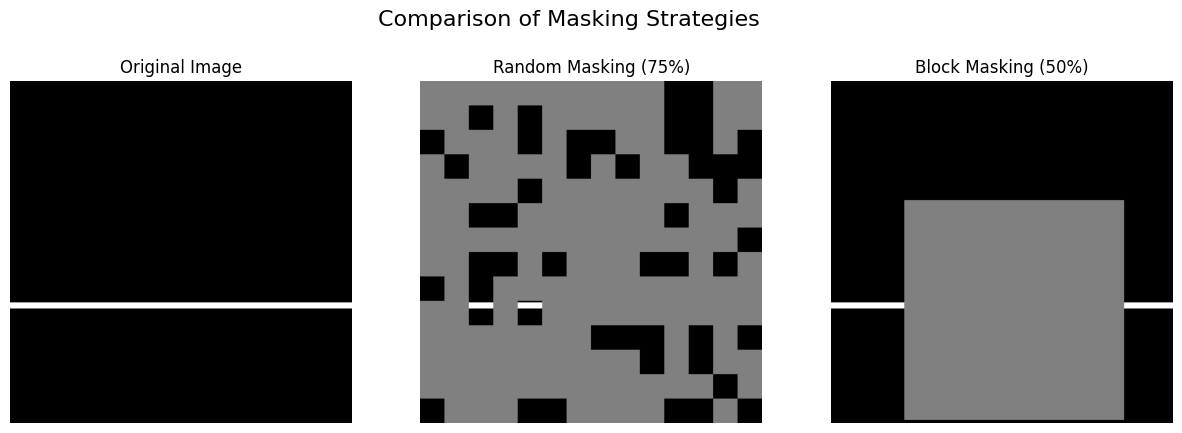

In [12]:
def visualize_masking_strategies(image_array, patch_size: int):

    # grey color for masked patches
    mask_col = [128, 128, 128] 
    img_h, img_width, _ = image_array.shape
    patches_h = img_h // patch_size
    patches_w = img_width // patch_size
    patches = patches_h * patches_w

    # 1. random masking
    rnd_masked_img = image_array.copy()
    mask_ratio_rnd = 0.75
    num_masked = int(patches * mask_ratio_rnd)
    masked_idxs = np.random.permutation(patches)[:num_masked]
    for idx in masked_idxs:
        row = (idx // patches_w) * patch_size
        col = (idx % patches_w) * patch_size
        rnd_masked_img[row:row+patch_size, col:col+patch_size] = mask_col

    # 2. block masking
    block_masked_img = image_array.copy()
    mask_ratio_block = 0.5
    block_h_patches = int(patches_h * np.sqrt(mask_ratio_block))
    block_w_patches = int(patches_w * np.sqrt(mask_ratio_block))
    block_h = block_h_patches * patch_size
    block_w = block_w_patches * patch_size
    row = random.randint(0, img_h - block_h)
    col = random.randint(0, img_width - block_w)
    block_masked_img[row:row+block_h, col:col+block_w] = mask_col


    fig, axis = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Comparison of Masking Strategies ', fontsize=16)

    axis[0].imshow(image_array)
    axis[0].set_title('Original Image')
    axis[0].axis('off')

    axis[1].imshow(rnd_masked_img)
    axis[1].set_title(f'Random Masking ({int(mask_ratio_rnd*100)}%)')
    axis[1].axis('off')
    
    axis[2].imshow(block_masked_img)
    axis[2].set_title(f'Block Masking ({int(mask_ratio_block*100)}%)')
    axis[2].axis('off')
    plt.savefig('comparison_masking_strategies.png')
    plt.show()

sample_image = generate_line_image(IMG_SIZE, 'horizontal', LENGTH)
visualize_masking_strategies(sample_image, patch_size=PATCH_SIZE)